## Data Challenge for Smartvid.io candidates:
### Cat vs Dog classifier using Keras
This notebook walks you through training a simple Cat vs Dog classifier.  Along the way are **5 questions** that you should answer. The demo model is very simple and you will have the opportunity to train your own model based on an existing network or one entirely your own. The goal is to show your ability to work with data within a toy problem. Please email this notebook to glong@smartvid.io when you are finished.

### Rules:
1) Use only the data provided

2) Test data cannot be used for training. No hand labeling the test set.

3) Show all of your work. Don't worry about making too many cells.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm import notebook

## Download the dataset

In [24]:
import requests

def download_file_from_google_drive(id, destination, total_size=0):
    """ General method for downloading from Google Drive.
    Doesn't require using API or having credentials
    :param id: Google Drive id for file (constant even if filename changes)
    :param destination: directory where to download the file
    """
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination, total_size)    

def get_confirm_token(response):
    """ Part of keep-alive method for downloading large files from Google Drive
    Discards packets of data that aren't the actual file
    :param response: session-based google query
    :return: either datapacket or discard unneeded data
    """
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination, total_size=0):
    CHUNK_SIZE = 32768

    with notebook.tqdm(desc=destination, total=total_size, unit='B', unit_scale=True) as pbar:
        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    pbar.update(CHUNK_SIZE)
                    f.write(chunk)
                
    print('Download Complete')

file_id = '1U60697DZ-t8-0iDpWC7ychdWJaOooE_9'
destination = './dogscats.zip'
download_file_from_google_drive(file_id, destination, total_size=592076674)


Download Complete


## Extract the zip file

In [25]:
import zipfile
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('./')

In [26]:
data_path = Path('./dogscats').absolute()
print(data_path)

/Users/garylong/workspace/smartvid-challenge/dogscats


In [27]:
print(os.listdir(data_path))

['valid', 'train', 'test2']


## Load data names and categories into a Pandas dataframe
The following function discovers the filenames and categories for the challenge

In [10]:
from os import fspath
def create_df(datapath : Path) -> pd.DataFrame:
    """
    Function to create a dataframe from a directory of jpgs
    
    Parameters:
    datapath (pathlib Path): path to the top level directory for training or validation
    
    Returns:
    df: Pandas dataframe consisting of 'filename' and 'category' columns
    """ 
    
    filenames = list(datapath.glob('**/*.jpg'))
    categories = []
    for filename in filenames:
        category = filename.stem.split('.')[0]
        categories.append(category)
    #fspath changes pathlib posixpath to str
    df = pd.DataFrame({
        'filename': [fspath(f) for f in filenames],
        'category': categories
    })
    
    return df

## Create dataframes for training and validation

In [11]:
df_train = create_df(data_path.joinpath('train'))
df_val = create_df(data_path.joinpath('valid'))

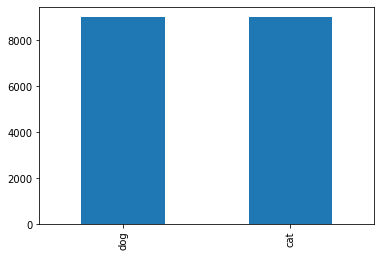

In [12]:
df_train['category'].value_counts().plot.bar()

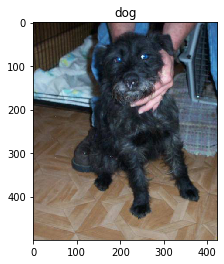

In [14]:
sample = df_val.sample(1)
image = load_img(sample.iloc[0]['filename'])
plt.title(sample.iloc[0]['category'])
plt.imshow(image)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

def create_base_model(image_hw : tuple):
    """
    Create a simple CNN model for the challenge
    
    Parameters:
    image_hw (tuple): A tuple (height, width) for the input images. Images will be resized to this input shape
    using a data generator.
    
    Returns:
    model: Keras model 
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                     padding='same', input_shape=(image_hw[0], image_hw[1], 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes
    
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

## Question 1)
Look over the base model. Is there something missing in the layers that could improve the training or performance of the simple model?

## Your Answer: 

## Question 2)
The model takes and image and predicts a categorical output, dog or cat. What loss function should be used if the model has a single output?

## Your Answer:

## Question 3)
Briefly discuss the advantages / disadvantages of making model that predicts Dog, Cat, or Other vs a simple Dog or Cat classifier.

## Your Answer:

## Create the base model and get a short summary of the parameters

In [32]:
IMAGE_SIZE = (128, 128)
base_model = create_base_model(IMAGE_SIZE)
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

In [20]:
total_train = df_train.shape[0]
total_val = df_val.shape[0]
batch_size=32  # adjust batch_size to fit in memory
print(f'Totals: train = {total_train}, val = {total_val}, batch = {batch_size}')

Totals: train = 18000, val = 2000, batch = 32


In [21]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df_train, 
    x_col='filename', #no need for directory because filenames are absolute paths
    y_col='category',
    target_size=IMAGE_SIZE, #(height, width)
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 18000 validated image filenames belonging to 2 classes.


In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 2000 validated image filenames belonging to 2 classes.


In [144]:
epochs=2
history = base_model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=None,
    workers=4
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 718 steps, validate for 62 steps
Epoch 1/2
718/718 [==============================] - 204s 284ms/step - loss: 0.6548 - accuracy: 0.6061 - val_loss: 0.6135 - val_accuracy: 0.6643
Epoch 2/2
718/718 [==============================] - 200s 279ms/step - loss: 0.5919 - accuracy: 0.6832 - val_loss: 0.5540 - val_accuracy: 0.7117


## Your model

For the rest of the notebook, implement your own model or use an existing model to train a dog vs cat classifier.  Write your own functions in the notebook to inspect / correct the training data, if necessary. Show your work and when you are happy with your model, evaluate it against the test set and submit the CSV.

## Question 4)
What are some things that you can do during training that can lead to a model that has better generality and performance on the test dataset?

## Your Answer

## Model Evalution / Submission
Run your model against the test set and prepare the output for submission

In [112]:
''' your model goes here '''

' your model goes here '

In [114]:
''' train your model here, store fit history in history variable '''

' train your model here, store fit history in history variable '

## Inspect model training / convergence
Run the block of code to track the history of your training

## Question 5)
Based on the graphs below, what can you say about your model and how it trained? 

In [82]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare test dataframe

In [28]:
test_filenames = os.listdir(data_path.joinpath('test2'))
df_test = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = df_test.shape[0]
print(f'Created test set with {nb_samples} samples')

Created test set with 5000 samples


In [30]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    df_test,
    str(data_path.joinpath('test2')),
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 5000 validated image filenames.


Replace the base_model variable with your model

In [33]:
predict = base_model.predict(test_generator, steps=np.ceil(nb_samples/batch_size), verbose=1)

157/157 [==============================] - 17s 107ms/step


The prediction for categorical classifcation will make a probability for each category that sums to 1. We will choose the category for the image that is the max.

In [34]:
df_test['category'] = np.argmax(predict, axis=-1)

In [35]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_test['category'] = df_test['category'].replace(label_map)
label_map

{0: 'cat', 1: 'dog'}

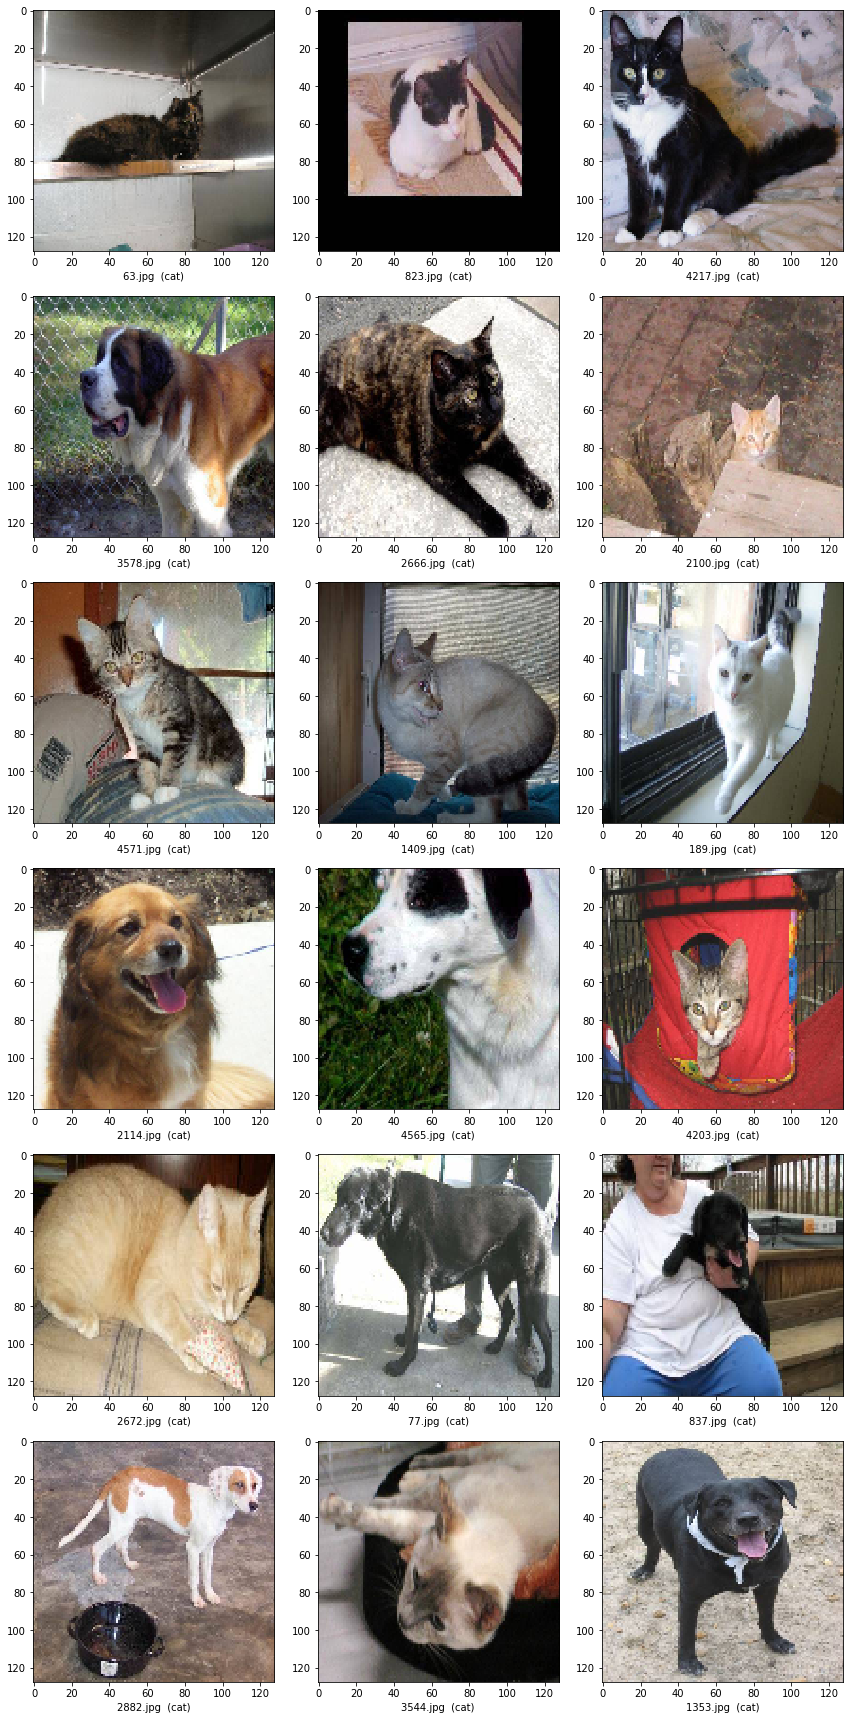

In [37]:
sample_test = df_test.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(str(data_path.joinpath('test2').joinpath(filename)), target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '  (' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Submission
Run the next block of code and mail the csv file to glong@smartvid.io

In [156]:
df_submission = df_test.copy()
df_submission['id'] = df_submission['filename'].str.split('.').str[0]
df_submission['label'] = df_submission['category']
df_submission.drop(['filename', 'category'], axis=1, inplace=True)
df_submission.to_csv('submission.csv', index=False)